<a href="https://colab.research.google.com/github/Jasn001/COMP_215/blob/main/labs/lab04-more_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 4
----------------
#### Name(s): Jasnpreet Singh
#### Date: 02/03/25

By the end of this lab you should be able to:
  * use composition and inheritance in a `class` to categorize related information


During this lab, you will be introduced to the following:
  * something, something



## Near Earth Objects (with more classes)

We'll continue working with Near Earth Object data using NASA's API: https://api.nasa.gov/.  In Lab 3 we defined an Asteroid class that contained a simple data structure.  In this lab, we will be Here's a brief review from Lab 2 on how to use the API.  

In [27]:
# import necessary modules
import datetime, json, requests, math
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt

### Review: make an API query

Here's a query that gets the record for a single NEO that recently passed by.

In [22]:
API_KEY = 'YmKw1It6tDJmPx9eYZbLTAqY9KSWyKUoW2zHeHFB'

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    #pprint(data)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

week_start = '2023-01-15'
neos = get_neos(week_start)
assert len(neos) > 0, f'Oh oh!  No NEOs found for {week_start}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
print(f"Record for NEO ID {neos[-1]['id']} is:")
pprint(neo)

70 Near Earth Objects found for week of 2023-01-15
Record for NEO ID 54054597 is:
{'absolute_magnitude_h': 26.9,
 'close_approach_data': [{'close_approach_date': '1900-07-02',
                          'close_approach_date_full': '1900-Jul-02 00:33',
                          'epoch_date_close_approach': -2193262020000,
                          'miss_distance': {'astronomical': '0.1109291518',
                                            'kilometers': '16594764.830186666',
                                            'lunar': '43.1514400502',
                                            'miles': '10311508.7144653508'},
                          'orbiting_body': 'Venus',
                          'relative_velocity': {'kilometers_per_hour': '28303.9767349711',
                                                'kilometers_per_second': '7.8622157597',
                                                'miles_per_hour': '17586.9904329047'}},
                         {'close_approach_date': '1900-

## Exercise 1: Define a CloseApproach class

Each NEO record comes with a list of `close_approach_data`, where each record in this list represents a single “close approach” to another orbiting body.
1. Develop a class named `CloseApproach` to represent a single close approach record.  State variables are

        neo (refrence to related NEO object)
        orbiting body (str)
        approach date (datetime object!)
        miss distance (float - choose units, document it, and be consistent!)
        relative velocity (ditto)
  
2. Define a "Factory" class method to construct a `CloseApproach` object from one close approach data record (a dictionary object). This method takes a `neo` object as input for the NEO to which the close approach data belongs. Remember to parse the date/time string into a datetime object.

In [23]:
class CloseApproach:
    """
    Represents a single close approach of a Near Earth Object (NEO) to an orbiting body.
    """

    def __init__(self, neo, orbiting_body, approach_date, miss_distance_km, relative_velocity_kms):
        self.neo = neo
        self.orbiting_body = orbiting_body
        self.approach_date = approach_date
        self.miss_distance_km = float(miss_distance_km)
        self.relative_velocity_kms = float(relative_velocity_kms)

    @classmethod
    def from_dict(cls, neo, data):
        """
        Factory method to create a CloseApproach instance from a dictionary record.
        """
        approach_date = datetime.strptime(data["close_approach_date"], "%Y-%m-%d")
        miss_distance_km = data["miss_distance"]["kilometers"]
        relative_velocity_kms = data["relative_velocity"]["kilometers_per_second"]

        return cls(neo, data["orbiting_body"], approach_date, miss_distance_km, relative_velocity_kms)

    def __repr__(self):
        return (f"CloseApproach(NEO={self.neo}, orbiting_body={self.orbiting_body}, "
                f"approach_date={self.approach_date}, miss_distance_km={self.miss_distance_km}, "
                f"relative_velocity_kms={self.relative_velocity_kms})")


## Exercise 2: Add list of CloseApproach objects to the Asteroid

Define an `Asteroid` class, like you did in Lab 3, but give the `Asteroid` list of “close approaches”.  This is called *composition* because each Asteroid object will be *composed* of CloseApproach objects (plus some other things).  There is bit of a catch-22 here because we need the `Asteroid` to construct the `CloseApproach` objects. The first two steps deal with that:

1. Add an instance variable to your Asteroid class with a default value of an empty list:

    ```
    close_approaches:list = []
    ```
      
2. In the Asteroid `from_NEO` factory, use a list comprehension to build the list of `CloseApproach` objects for the Asteroid instance, and then set the instance's `close_approaches` variable before returning it. Setting the value of an object's instance variables from outside the class is generally frowned upon - this is why we make the factory a method of the class itself.

3. Add a method to `Asteroid` to return the `CloseApproach` object for the nearest miss (ie. smallest `missed_distance`):
    ```
    def nearest_miss(self):
        ...
    ```

4. Add a method to the Asteroid class, `closest_earth_approach`, that returns the CloseApproach object that represents the closest approach the Asteroid makes to Earth.
    ```
    def closest_earth_approach(self):
        ...
    ```

Write some test code to demonstrate these new features.

In [24]:
class Asteroid:
    """
    Represents an asteroid with a list of close approaches.
    """
    def __init__(self, name, diameter, hazardous, close_approaches=None):
        self.name = name
        self.diameter = float(diameter)
        self.hazardous = hazardous
        self.close_approaches = close_approaches if close_approaches else []

    @classmethod
    def from_neo(cls, data):
        close_approaches = [CloseApproach.from_dict(None, approach) for approach in data["close_approach_data"]]
        asteroid = cls(data["name"], data["estimated_diameter"]["kilometers"]["estimated_diameter_max"], data["is_potentially_hazardous_asteroid"], close_approaches)
        for approach in asteroid.close_approaches:
            approach.neo = asteroid  # Link CloseApproach objects to this asteroid
        return asteroid

    def nearest_miss(self):
        """Returns the CloseApproach object with the smallest miss distance."""
        return min(self.close_approaches, key=lambda ca: ca.miss_distance_km, default=None)

    def closest_earth_approach(self):
        """Returns the CloseApproach object that represents the closest approach to Earth."""
        return min((ca for ca in self.close_approaches if ca.orbiting_body.lower() == "earth"), key=lambda ca: ca.miss_distance_km, default=None)

    def __repr__(self):
        return f"Asteroid(name={self.name}, diameter={self.diameter}, hazardous={self.hazardous}, close_approaches={len(self.close_approaches)})"

# Example Test Code
if __name__ == "__main__":
    example_data = {
        "name": "Apophis",
        "estimated_diameter": {"kilometers": {"estimated_diameter_max": 0.375}},
        "is_potentially_hazardous_asteroid": True,
        "close_approach_data": [
            {"orbiting_body": "Earth", "close_approach_date": "2029-04-13", "miss_distance": {"kilometers": "31800"}, "relative_velocity": {"kilometers_per_second": "7.4"}},
            {"orbiting_body": "Mars", "close_approach_date": "2036-04-13", "miss_distance": {"kilometers": "1000000"}, "relative_velocity": {"kilometers_per_second": "5.2"}}
        ]
    }

    apophis = Asteroid.from_neo(example_data)
    print(apophis)
    print("Nearest Miss:", apophis.nearest_miss())
    print("Closest Earth Approach:", apophis.closest_earth_approach())


Asteroid(name=Apophis, diameter=0.375, hazardous=True, close_approaches=2)
Nearest Miss: CloseApproach(NEO=Asteroid(name=Apophis, diameter=0.375, hazardous=True, close_approaches=2), orbiting_body=Earth, approach_date=2029-04-13 00:00:00, miss_distance_km=31800.0, relative_velocity_kms=7.4)
Closest Earth Approach: CloseApproach(NEO=Asteroid(name=Apophis, diameter=0.375, hazardous=True, close_approaches=2), orbiting_body=Earth, approach_date=2029-04-13 00:00:00, miss_distance_km=31800.0, relative_velocity_kms=7.4)


## Exercise 3: Plot the Closest Approaches

Write a function that takes an Asteroid object as a parameter and makes a timeline plot of close approaches.  You may wish to use the `matplotlib.pyplot` `plot` object.  Here is an example of a timeline plot for the asteroid with neo id '54339874'

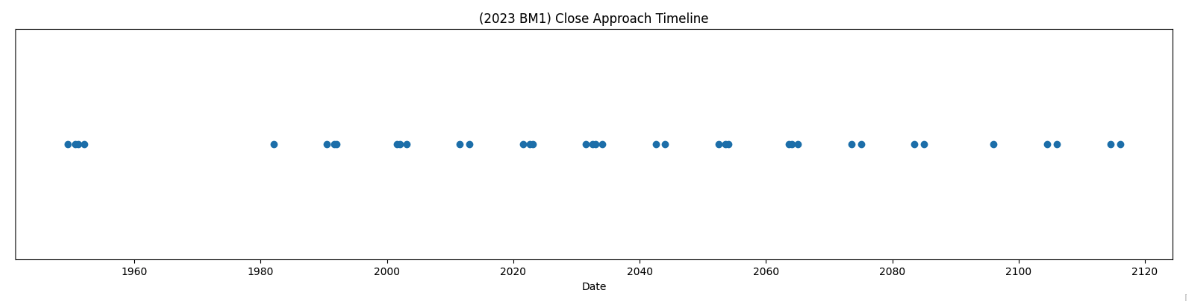

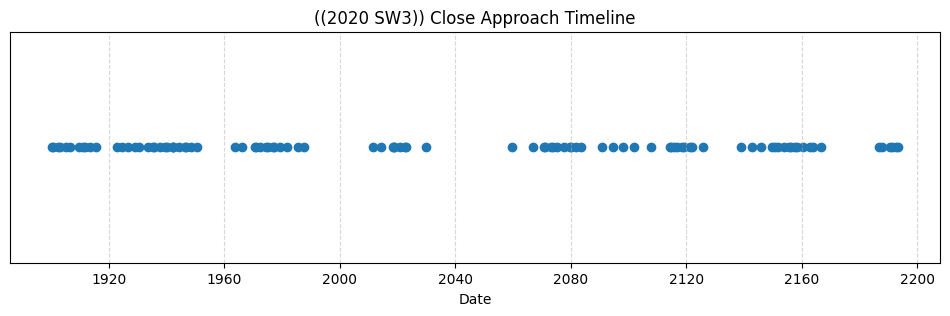

In [26]:
def fetch_asteroid_data(neo_id):
    """
    Fetches asteroid data from NASA's NEO API using the given NEO ID.
    """
    url = f"https://api.nasa.gov/neo/rest/v1/neo/{neo_id}?api_key={API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Error fetching asteroid data.")
        return None

def plot_close_approaches(neo_id):
    """
    Fetches asteroid data using the given NEO ID and plots a timeline of its close approaches.
    """
    data = fetch_asteroid_data(neo_id)
    if not data:
        return

    name = data["name"]
    close_approaches = data.get("close_approach_data", [])

    if not close_approaches:
        print("No close approach data available for this asteroid.")
        return

    dates = [datetime.strptime(approach["close_approach_date"], "%Y-%m-%d") for approach in close_approaches]
    y_values = [1] * len(dates)  # Single row of points for a timeline effect

    plt.figure(figsize=(12, 3))
    plt.scatter(dates, y_values, marker='o')
    plt.title(f"({name}) Close Approach Timeline")
    plt.xlabel("Date")
    plt.yticks([])  # Hide y-axis labels for clarity
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    plt.show()

# Example usage
plot_close_approaches("54054597")  # Replace with any valid NEO ID



## Challenge - Take your skills to the next level...

 With these data structures in place, we can now start answering all kinds of interesting questions about a single Asteroid or a set of Asteroids.  
Here’s a couple ideas to try:



* write a **function** named `most_dangerous_approach`, that takes a date range and returns a single “potentially hazardous” Asteroid object that makes the closest approach to Earth in within that range.  Your algorithm will ultimately need to:
    * grab the list of NEO’s for the given date range;
    * use a list comprehension to build the list of Asteroid objects for the NEO’s returned
    * use a list comprehension to filter  potentially hazardous Asteroids only;
    * use a list comprehension to map each Asteroid to its  closest_earth_approach
    * apply Python’s min function to identify the Asteroid with the closest_earth_approach

You may want to decompose some of these steps into smaller functions.
* add a method to the Asteroid class, estimated_mass, that computes an estimate of the Asteroid’s mass based on its diameter.  This is a model – state your assumptions.
* add a method to the CloseApproach class, impact_force,  that estimates the force of impact if the Asteroid hit the orbiting object.  Again, this is a model, state your assumptions.

In [28]:
class CloseApproach:
    """Represents a single close approach record of an asteroid to an orbiting body."""

    def __init__(self, neo, orbiting_body, approach_date, miss_distance_km, relative_velocity_km_s):
        self.neo = neo  # Reference to the related Asteroid object
        self.orbiting_body = orbiting_body
        self.approach_date = datetime.strptime(approach_date, "%Y-%m-%d")
        self.miss_distance_km = float(miss_distance_km)  # Distance in km
        self.relative_velocity_km_s = float(relative_velocity_km_s)  # Velocity in km/s

    @classmethod
    def from_dict(cls, neo, data):
        """Factory method to create a CloseApproach object from a dictionary."""
        return cls(
            neo=neo,
            orbiting_body=data["orbiting_body"],
            approach_date=data["close_approach_date"],
            miss_distance_km=data["miss_distance"]["kilometers"],
            relative_velocity_km_s=data["relative_velocity"]["kilometers_per_second"]
        )

    def impact_force(self):
        """
        Estimates the impact force if the asteroid were to collide with the orbiting object.
        Assumptions:
        - Kinetic energy formula: KE = 0.5 * mass * velocity^2
        - Asteroid density assumed to be 2,600 kg/m³ (typical for stony asteroids)
        - Mass is derived using estimated diameter (provided in Asteroid class)
        """
        volume = (4/3) * math.pi * (self.neo.estimated_diameter_m / 2) ** 3  # Sphere volume
        density = 2600  # kg/m³ (average density of stony asteroids)
        mass = volume * density  # Estimate mass in kg
        velocity = self.relative_velocity_km_s * 1000  # Convert to m/s

        impact_energy = 0.5 * mass * (velocity ** 2)  # Joules
        return impact_energy


class Asteroid:
    """Represents an Asteroid object with a list of its close approaches."""

    def __init__(self, neo_id, name, diameter_m, hazardous):
        self.neo_id = neo_id
        self.name = name
        self.estimated_diameter_m = float(diameter_m)
        self.hazardous = hazardous
        self.close_approaches = []  # List of CloseApproach objects

    @classmethod
    def from_dict(cls, data):
        """Factory method to create an Asteroid object from a dictionary."""
        asteroid = cls(
            neo_id=data["id"],
            name=data["name"],
            diameter_m=data["estimated_diameter"]["meters"]["estimated_diameter_max"],
            hazardous=data["is_potentially_hazardous_asteroid"]
        )

        # Build the list of close approaches
        asteroid.close_approaches = [
            CloseApproach.from_dict(asteroid, approach) for approach in data.get("close_approach_data", [])
        ]

        return asteroid

    def nearest_miss(self):
        """Returns the CloseApproach object with the smallest miss distance."""
        return min(self.close_approaches, key=lambda x: x.miss_distance_km, default=None)

    def closest_earth_approach(self):
        """Returns the CloseApproach object that represents the closest approach to Earth."""
        earth_approaches = [approach for approach in self.close_approaches if approach.orbiting_body == "Earth"]
        return min(earth_approaches, key=lambda x: x.miss_distance_km, default=None)

    def estimated_mass(self):
        """
        Estimates the asteroid's mass based on its diameter.
        """
        radius = self.estimated_diameter_m / 2
        volume = (4/3) * math.pi * (radius ** 3)
        density = 2600  # kg/m³ (for a stony asteroid)
        return volume * density  # Mass in kg


def fetch_neos(start_date, end_date):
    """Fetches Near Earth Objects for a given date range from NASA's API."""
    url = f"https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&end_date={end_date}&api_key={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        neos = []
        for date in data["near_earth_objects"]:
            for neo in data["near_earth_objects"][date]:
                neos.append(Asteroid.from_dict(neo))
        return neos
    else:
        print("Error fetching NEO data.")
        return []


def most_dangerous_approach(start_date, end_date):
    """
    Returns the most potentially hazardous asteroid with the closest Earth approach in the given date range.
    """
    neos = fetch_neos(start_date, end_date)

    hazardous_neos = [neo for neo in neos if neo.hazardous]

    if not hazardous_neos:
        print("No potentially hazardous asteroids found in this date range.")
        return None

    closest_approach_asteroid = min(
        hazardous_neos,
        key=lambda neo: neo.closest_earth_approach().miss_distance_km if neo.closest_earth_approach() else float("inf"),
        default=None
    )

    return closest_approach_asteroid


# Example Usage
start_date = "2025-02-01"
end_date = "2025-02-07"

dangerous_asteroid = most_dangerous_approach(start_date, end_date)
if dangerous_asteroid:
    print(f"Most Dangerous Asteroid: {dangerous_asteroid.name}")
    print(f"Estimated Mass: {dangerous_asteroid.estimated_mass()} kg")
    closest_approach = dangerous_asteroid.closest_earth_approach()
    if closest_approach:
        print(f"Closest Approach Distance: {closest_approach.miss_distance_km} km")
        print(f"Impact Force Estimate: {closest_approach.impact_force()} Joules")


Most Dangerous Asteroid: 6239 Minos (1989 QF)
Estimated Mass: 2004896264194.7048 kg
Closest Approach Distance: 14819302.003929347 km
Impact Force Estimate: 1.0381070019259982e+20 Joules
